In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt


import os
import multiprocessing
from tqdm import tqdm

import numpy as np

# Determine if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
if device.type == "cuda":
    num_workers = 4
else:
    num_workers = multiprocessing.cpu_count()

In [3]:
HEIGHT, WIDTH = 128, 128

---

# DataLoading
## For Original Model

In [4]:
class EcgDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

    @property
    def classes(self):
        return self.data.classes

In [5]:
# class GrayscaleConversion:
#     def __call__(self, image):
#         return image.convert('L')

In [6]:
# class PermuteTensor:
#     def __call__(self, tensor):
#         return tensor.permute(1, 2, 0)

In [7]:
# transformer = transforms.Compose([
#     GrayscaleConversion(),  # Convert to grayscale
#     transforms.ToTensor(),  # Convert images to PyTorch tensors
#     # PermuteTensor(),  # Permute the tensor dimensions
# ])

In [8]:
# dataset = EcgDataset(
#     data_dir='/content/drive/MyDrive/colab_notebooks/projects/ecg/cleaned_dataset/train',
#     transform=transformer
# )

In [9]:
# dataset.classes

In [10]:
# train_loader = DataLoader(
#     dataset,
#     batch_size=64,
#     shuffle=True,
#     num_workers=num_workers,
#     pin_memory=True  # This can speed up host to GPU transfers
# )

In [11]:
# for images, labels in train_loader:
#     print(images.shape, labels.shape)
#     break

In [12]:
# for images, labels in train_loader:
#     for image, label in zip(images, labels):
#         plt.figure(figsize=(15,15))
#         plt.imshow(image.permute(1,2,0), cmap='gray') # I permuted the image!
#         plt.title(f"Label: {dataset.classes[label]}")
#         plt.axis('off')
#         plt.show()
#         print(image.shape)
#         break
#     break

---

#    <center> Model </center>
## <center> Original Model </center>
### <center> <u> Need to modify dimensions </u> </center>

In [13]:
# """
# https://asiltureli.github.io/Convolution-Layer-Calculator/
# """
# class ECG_Classifier(nn.Module):
#     def __init__(self, num_of_classes):
#         super().__init__()
#         self.conv1 = nn.Conv2d(in_channels=1,
#                                out_channels=6,
#                                kernel_size=5)

#         self.pool = nn.MaxPool2d(kernel_size=2,
#                                  stride=2)

#         self.conv2 = nn.Conv2d(in_channels=6,
#                                out_channels=16,
#                                kernel_size=5)

#         self.fc1 = nn.Linear(in_features=16 * 5 * 5,
#                              out_features=120)

#         self.fc2 = nn.Linear(in_features=120,
#                              out_features=84)

#         self.fc3 = nn.Linear(in_features=84,
#                              out_features=num_of_classes)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         print(x.shape)
#         x = self.pool(F.relu(self.conv2(x)))
#         print(x.shape)
#         x = torch.flatten(x, 1) # flatten all dimensions except batch
#         print(x.shape)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

In [14]:
# model = ECG_Classifier(num_of_classes = len(dataset.classes))
# model.to(device)

---

#    <center> Model </center>
## <center> Transfer Learning </center>

In [15]:
# !pip install timm

In [16]:
import timm

In [23]:
transform = transforms.Compose(
    [
        transforms.Resize((HEIGHT, WIDTH)),
        transforms.ToTensor(),
        transforms.Grayscale(num_output_channels=1),
    ]
)

In [24]:
train_dataset = EcgDataset(
    data_dir="/content/drive/MyDrive/colab_notebooks/projects/ecg/cleaned_dataset/train",
    transform=transform,
)

test_dataset = EcgDataset(
    data_dir="/content/drive/MyDrive/colab_notebooks/projects/ecg/cleaned_dataset/test",
    transform=transform,
)

In [25]:
train_dataset.classes, test_dataset.classes

(['abnormal_heartbeat', 'mi', 'mi_history', 'normal'],
 ['abnormal_heartbeat', 'mi', 'mi_history', 'normal'])

In [26]:
train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,  # This can speed up host to GPU transfers
)

test_loader = DataLoader(
    test_dataset,
    batch_size=20,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,  # This can speed up host to GPU transfers
)

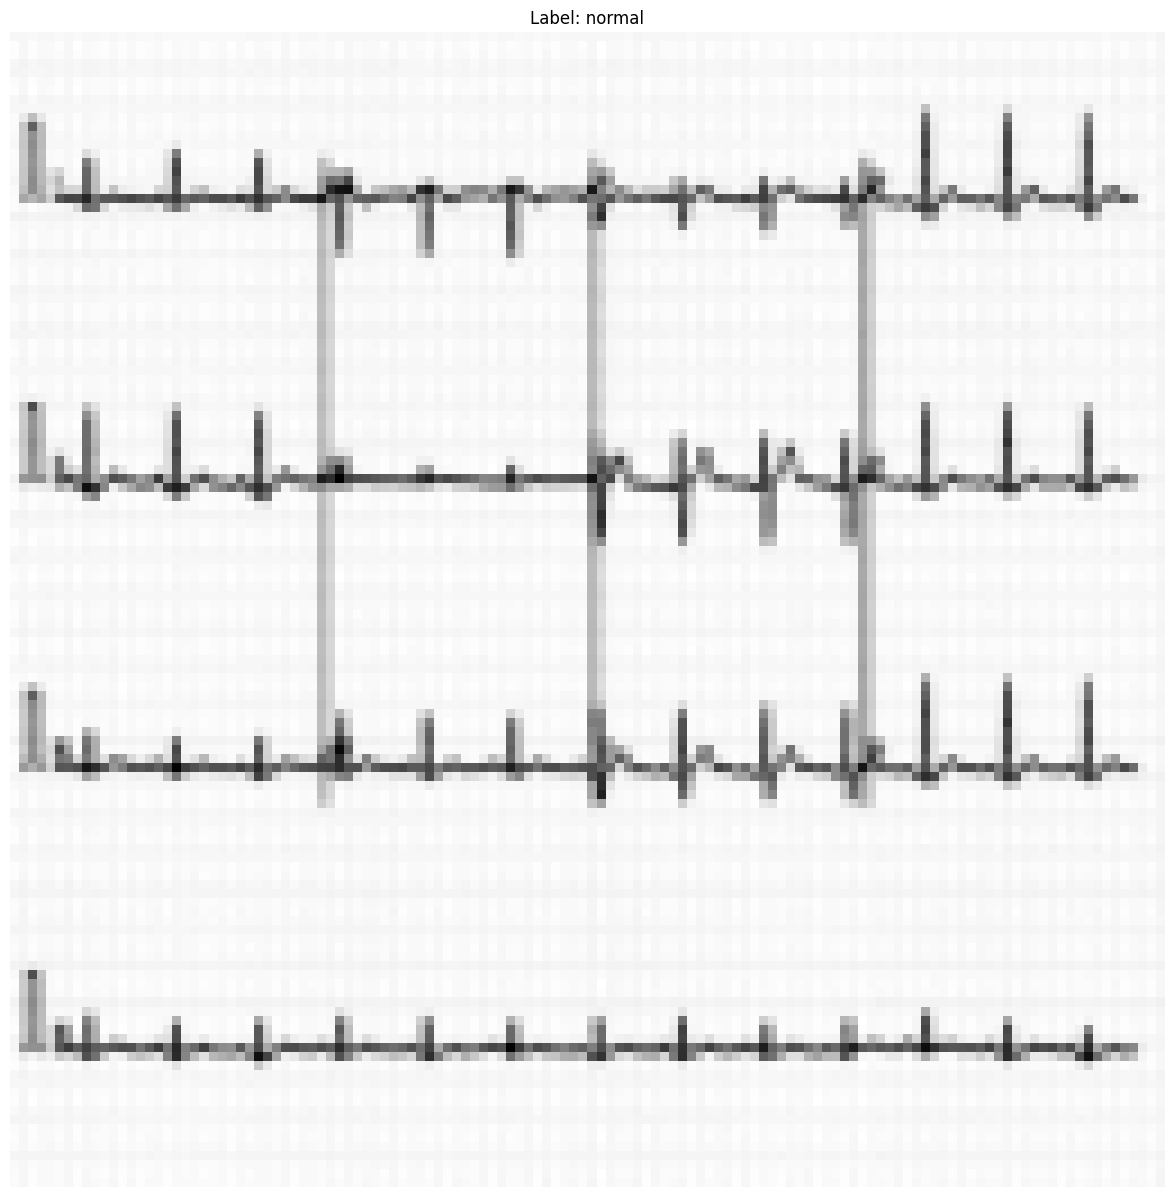

torch.Size([1, 128, 128])


In [27]:
for images, labels in train_loader:
    for image, label in zip(images, labels):
        plt.figure(figsize=(15, 15))
        plt.imshow(image.permute(1, 2, 0), cmap="gray")  # I permuted the image!
        plt.title(f"Label: {train_dataset.classes[label]}")
        plt.axis("off")
        plt.show()
        print(image.shape)
        break
    break

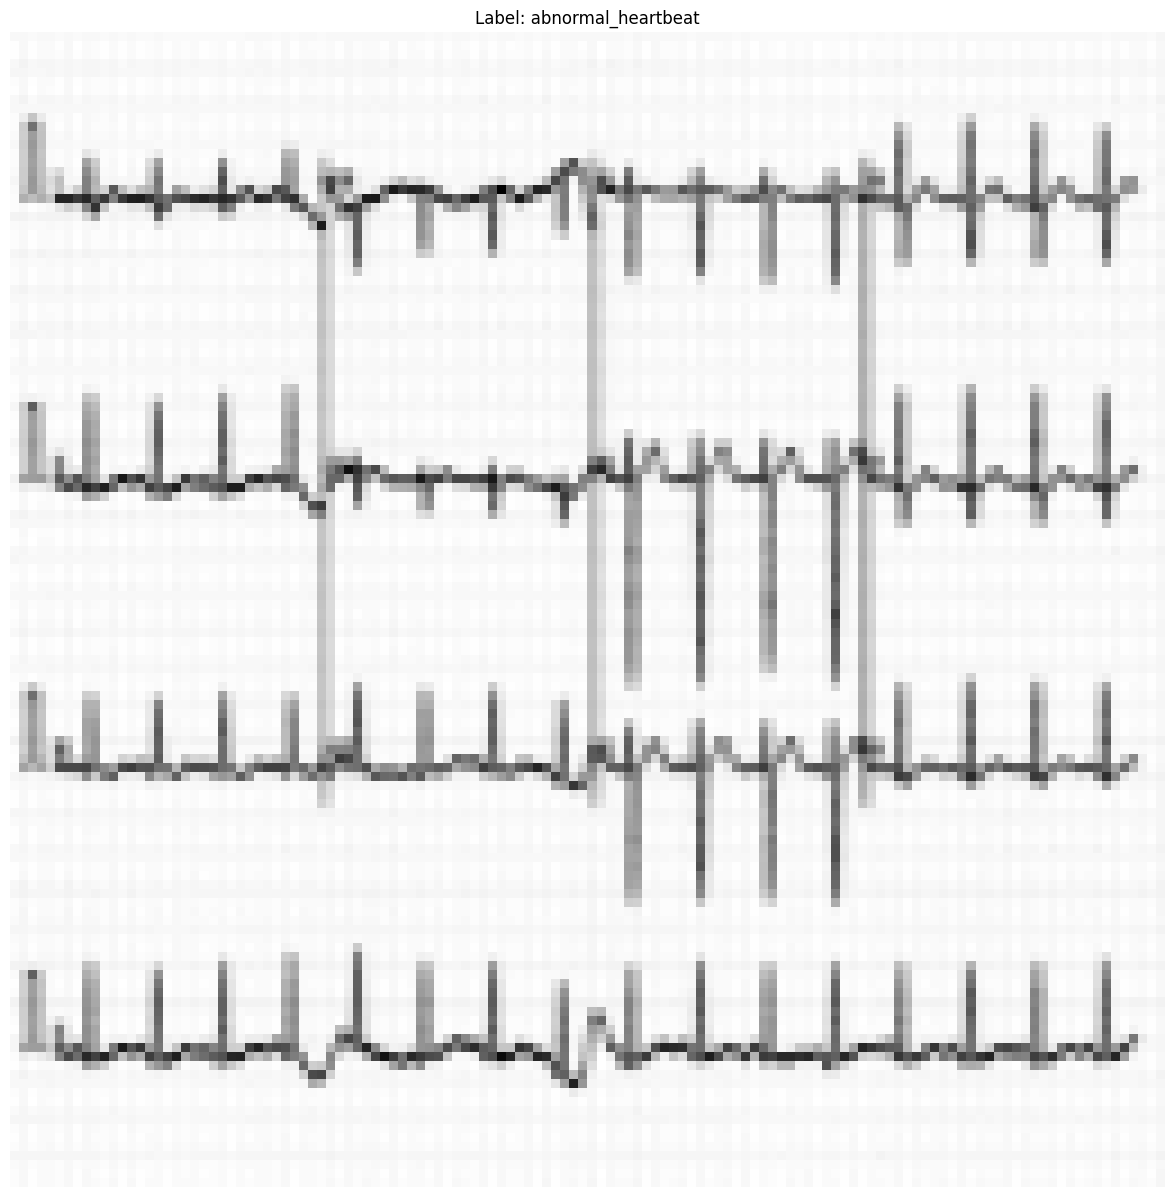

torch.Size([1, 128, 128])


In [28]:
for images, labels in test_loader:
    for image, label in zip(images, labels):
        plt.figure(figsize=(15, 15))
        plt.imshow(image.permute(1, 2, 0), cmap="gray")  # I permuted the image!
        plt.title(f"Label: {test_dataset.classes[label]}")
        plt.axis("off")
        plt.show()
        print(image.shape)
        break
    break

In [35]:
class ECG_Classifier(nn.Module):
    def __init__(self, num_classes=len(train_dataset.classes)):
        super(ECG_Classifier, self).__init__()

        # Create the base model
        self.base_model = timm.create_model("efficientnet_b0", pretrained=True)

        # Modify the first convolution layer to accept 1-channel input
        # Get the original first conv layer
        original_conv = self.base_model.conv_stem

        # New conv layer with 1 input channel (grayscale)
        self.base_model.conv_stem = nn.Conv2d(
            in_channels=1,  # Changed from 3 to 1
            out_channels=original_conv.out_channels,
            kernel_size=original_conv.kernel_size,
            stride=original_conv.stride,
            padding=original_conv.padding,
            bias=False if original_conv.bias is None else True,
        )

        # If using pretrained weights, we need to adapt the weights for the new conv layer
        if original_conv.weight is not None:
            # Average the weights across the 3 channels to create weights for 1 channel
            new_weight = original_conv.weight.data.mean(dim=1, keepdim=True)
            self.base_model.conv_stem.weight.data = new_weight

        self.features = nn.Sequential(*list(self.base_model.children())[:-1])

        enet_out_size = 1280
        self.classifier = nn.Sequential(
            nn.Flatten(), nn.Linear(enet_out_size, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        output = self.classifier(x)
        return output

In [36]:
model = ECG_Classifier(num_classes=len(train_dataset.classes))
model.to(device)

ECG_Classifier(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_p

---

In [37]:
EPOCHS = 35
LEARNING_RATE = 0.001

In [38]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    model.parameters(),
    lr=LEARNING_RATE,
    momentum=0.9,
)

In [39]:
for images, labels in train_loader:
    print(images.shape, labels.shape)
    break

torch.Size([64, 1, 128, 128]) torch.Size([64])


In [40]:
for epoch in range(EPOCHS):
    running_loss = 0.0
    # training loop
    model.train()
    for images, labels in tqdm(train_loader, desc="Training Loop"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

Training Loop: 100%|██████████| 12/12 [00:12<00:00,  1.01s/it]


Epoch 1, Loss: 1.341668576002121


Training Loop: 100%|██████████| 12/12 [00:05<00:00,  2.18it/s]


Epoch 2, Loss: 1.169707824786504


Training Loop: 100%|██████████| 12/12 [00:05<00:00,  2.23it/s]


Epoch 3, Loss: 0.9622204303741455


Training Loop: 100%|██████████| 12/12 [00:05<00:00,  2.21it/s]


Epoch 4, Loss: 0.770119791229566


Training Loop: 100%|██████████| 12/12 [00:05<00:00,  2.17it/s]


Epoch 5, Loss: 0.603611687819163


Training Loop: 100%|██████████| 12/12 [00:05<00:00,  2.21it/s]


Epoch 6, Loss: 0.49140234539906186


Training Loop: 100%|██████████| 12/12 [00:05<00:00,  2.17it/s]


Epoch 7, Loss: 0.3826395496726036


Training Loop: 100%|██████████| 12/12 [00:05<00:00,  2.27it/s]


Epoch 8, Loss: 0.3071762298544248


Training Loop: 100%|██████████| 12/12 [00:05<00:00,  2.17it/s]


Epoch 9, Loss: 0.26293373728791875


Training Loop: 100%|██████████| 12/12 [00:05<00:00,  2.26it/s]


Epoch 10, Loss: 0.22412720943490663


Training Loop: 100%|██████████| 12/12 [00:05<00:00,  2.22it/s]


Epoch 11, Loss: 0.19853579252958298


Training Loop: 100%|██████████| 12/12 [00:05<00:00,  2.17it/s]


Epoch 12, Loss: 0.15616492430369058


Training Loop: 100%|██████████| 12/12 [00:05<00:00,  2.23it/s]


Epoch 13, Loss: 0.1368686327089866


Training Loop: 100%|██████████| 12/12 [00:05<00:00,  2.11it/s]


Epoch 14, Loss: 0.11923413164913654


Training Loop: 100%|██████████| 12/12 [00:05<00:00,  2.19it/s]


Epoch 15, Loss: 0.10656799810628097


Training Loop: 100%|██████████| 12/12 [00:05<00:00,  2.15it/s]


Epoch 16, Loss: 0.09378199651837349


Training Loop: 100%|██████████| 12/12 [00:05<00:00,  2.21it/s]


Epoch 17, Loss: 0.08648796441654365


Training Loop: 100%|██████████| 12/12 [00:05<00:00,  2.18it/s]


Epoch 18, Loss: 0.07166390834997098


Training Loop: 100%|██████████| 12/12 [00:05<00:00,  2.21it/s]


Epoch 19, Loss: 0.07233385182917118


Training Loop: 100%|██████████| 12/12 [00:05<00:00,  2.24it/s]


Epoch 20, Loss: 0.06571098944793145


Training Loop: 100%|██████████| 12/12 [00:05<00:00,  2.14it/s]


Epoch 21, Loss: 0.053541456970075764


Training Loop: 100%|██████████| 12/12 [00:05<00:00,  2.24it/s]


Epoch 22, Loss: 0.05432062937567631


Training Loop: 100%|██████████| 12/12 [00:05<00:00,  2.17it/s]


Epoch 23, Loss: 0.043687916516015925


Training Loop: 100%|██████████| 12/12 [00:05<00:00,  2.20it/s]


Epoch 24, Loss: 0.04407088722412785


Training Loop: 100%|██████████| 12/12 [00:05<00:00,  2.17it/s]


Epoch 25, Loss: 0.0388653795234859


Training Loop: 100%|██████████| 12/12 [00:05<00:00,  2.23it/s]


Epoch 26, Loss: 0.037447163524727024


Training Loop: 100%|██████████| 12/12 [00:05<00:00,  2.24it/s]


Epoch 27, Loss: 0.03492278947184483


Training Loop: 100%|██████████| 12/12 [00:05<00:00,  2.17it/s]


Epoch 28, Loss: 0.02856475968534748


Training Loop: 100%|██████████| 12/12 [00:05<00:00,  2.24it/s]


Epoch 29, Loss: 0.0327010132993261


Training Loop: 100%|██████████| 12/12 [00:05<00:00,  2.14it/s]


Epoch 30, Loss: 0.03564460932587584


Training Loop: 100%|██████████| 12/12 [00:05<00:00,  2.22it/s]


Epoch 31, Loss: 0.02994251111522317


Training Loop: 100%|██████████| 12/12 [00:05<00:00,  2.18it/s]


Epoch 32, Loss: 0.023969506844878197


Training Loop: 100%|██████████| 12/12 [00:05<00:00,  2.21it/s]


Epoch 33, Loss: 0.023348978410164516


Training Loop: 100%|██████████| 12/12 [00:05<00:00,  2.23it/s]


Epoch 34, Loss: 0.024785667657852173


Training Loop: 100%|██████████| 12/12 [00:05<00:00,  2.19it/s]

Epoch 35, Loss: 0.019824163212130468


# <center> <u> Predictions </u> </center>

In [41]:
# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

In [42]:
# Visualization
def visualize_predictions(original_image, probabilities, class_names, label):
    fig, axarr = plt.subplots(1, 2, figsize=(8, 4))

    # Display image
    axarr[0].imshow(original_image[0], cmap="gray")
    axarr[0].axis("off")
    axarr[0].set_title(f"True ECG: {test_dataset.classes[label]}")

    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

In [43]:
test_dataset.classes

['abnormal_heartbeat', 'mi', 'mi_history', 'normal']

Most Probable Scenerio: abnormal_heartbeat


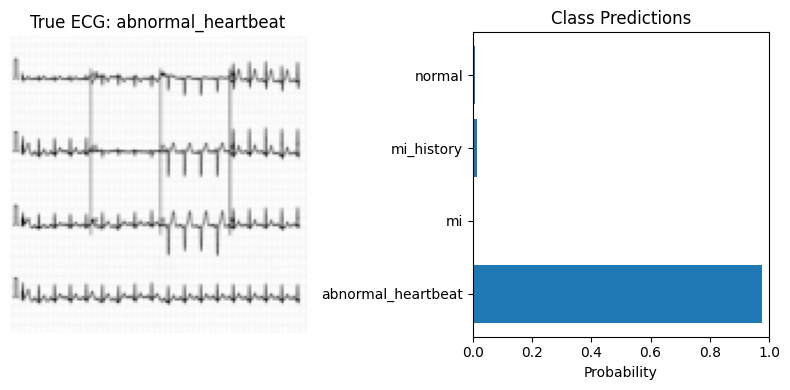

Most Probable Scenerio: mi


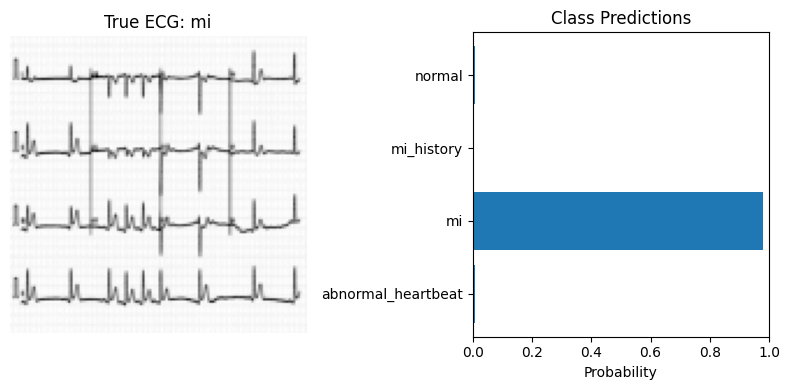

Most Probable Scenerio: mi


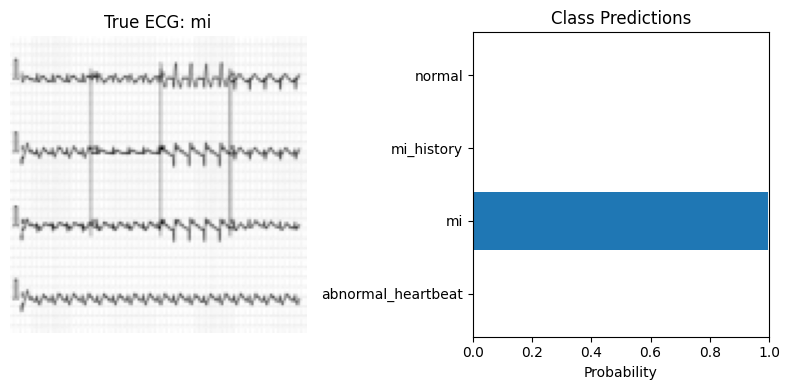

Most Probable Scenerio: abnormal_heartbeat


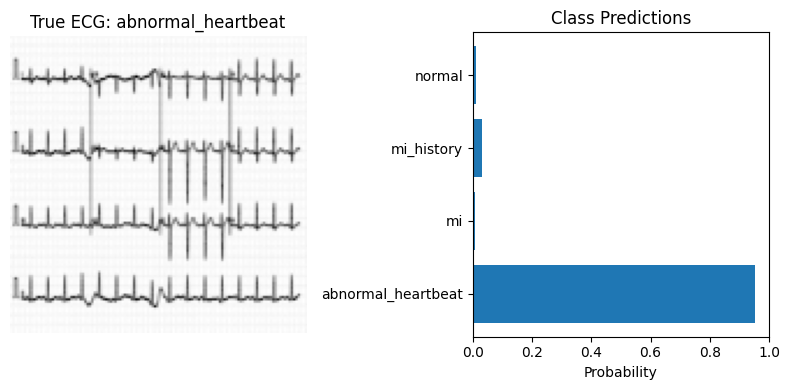

Most Probable Scenerio: mi_history


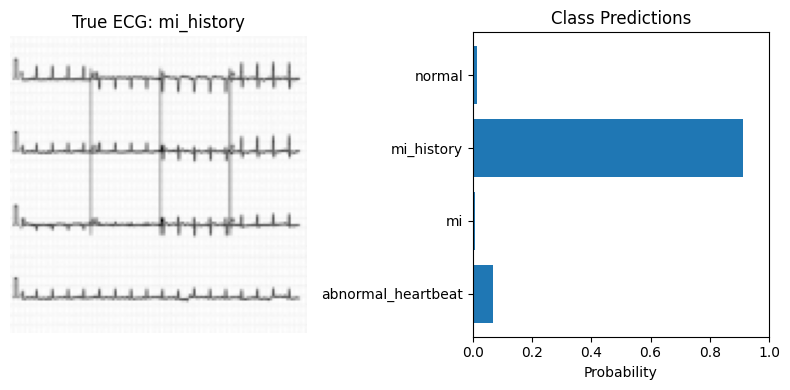

Most Probable Scenerio: normal


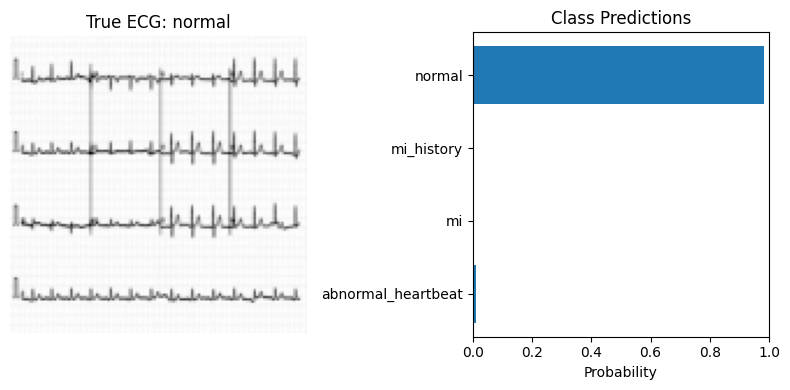

Most Probable Scenerio: normal


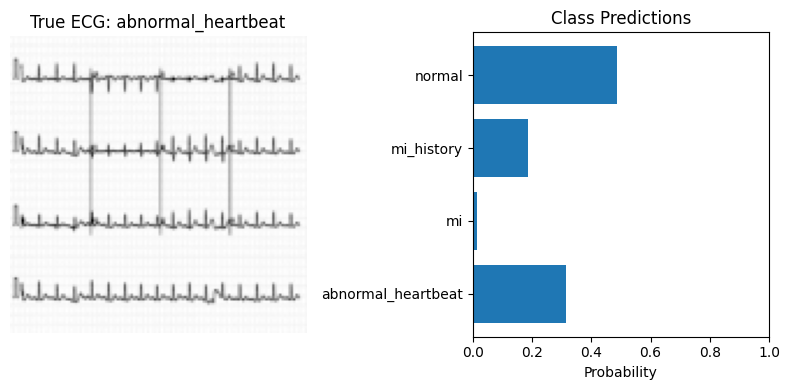

Most Probable Scenerio: normal


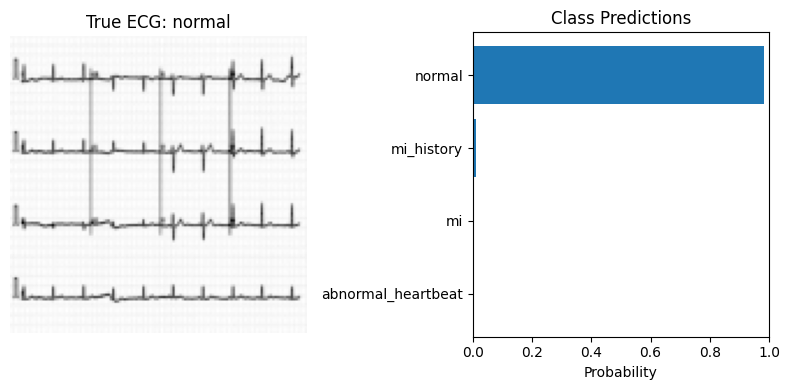

Most Probable Scenerio: normal


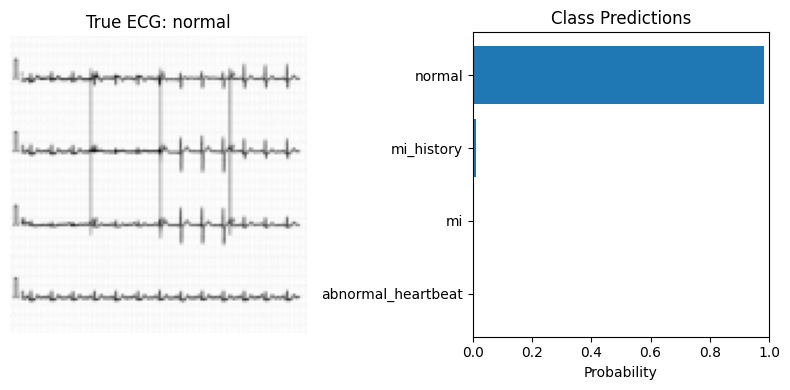

Most Probable Scenerio: mi_history


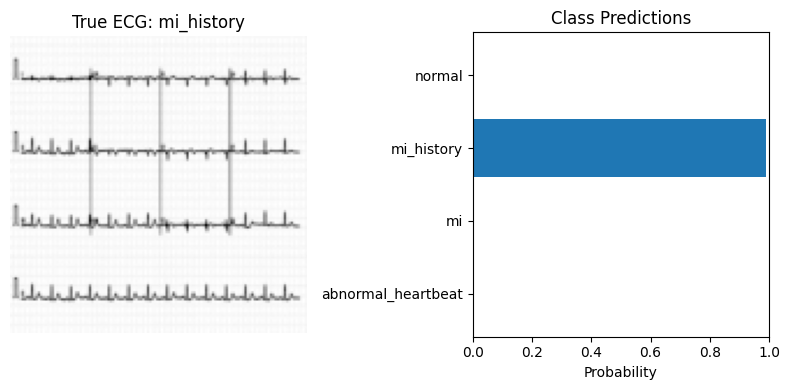

Most Probable Scenerio: mi


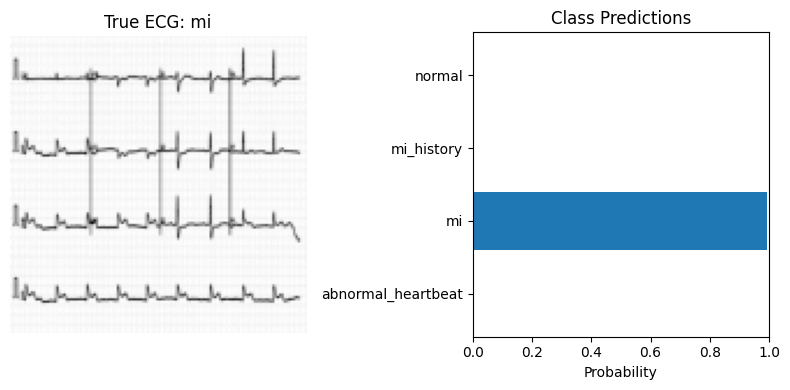

Most Probable Scenerio: mi


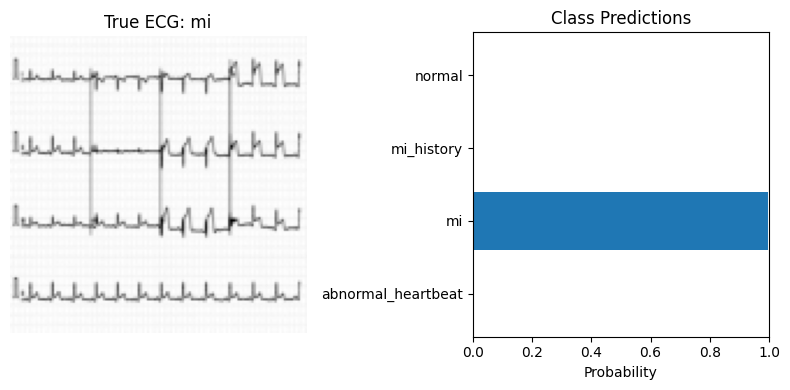

Most Probable Scenerio: mi_history


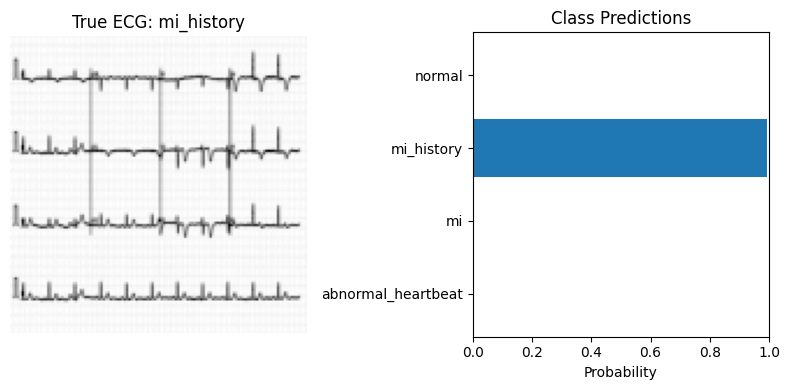

Most Probable Scenerio: normal


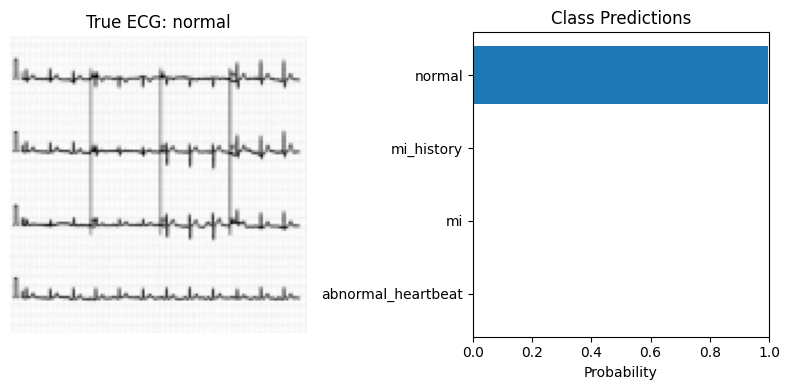

Most Probable Scenerio: abnormal_heartbeat


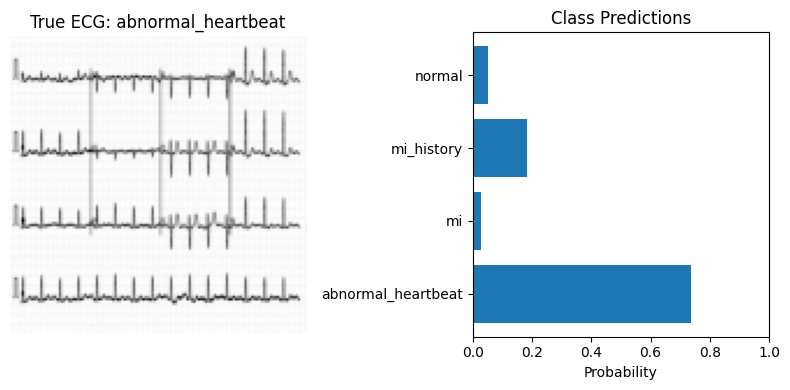

Most Probable Scenerio: normal


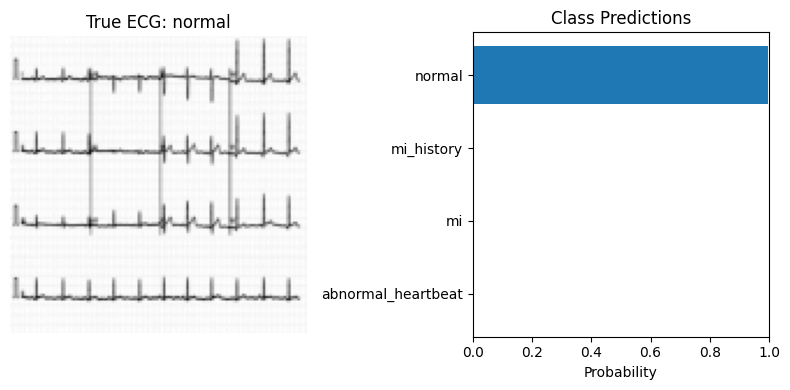

Most Probable Scenerio: abnormal_heartbeat


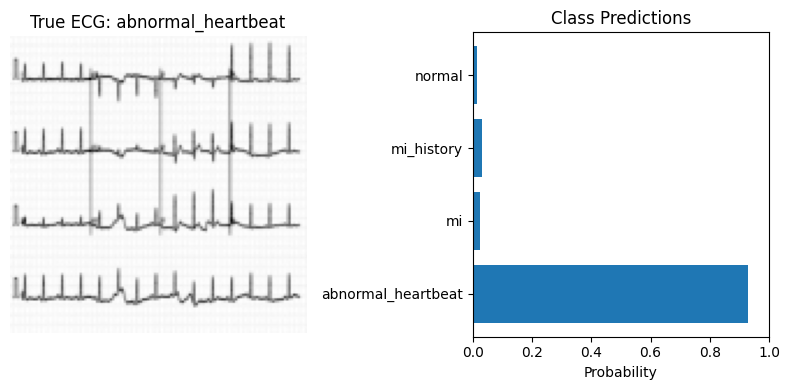

Most Probable Scenerio: mi_history


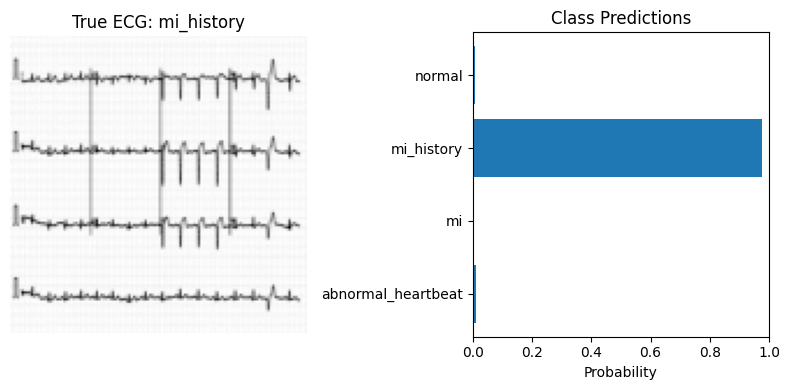

Most Probable Scenerio: mi


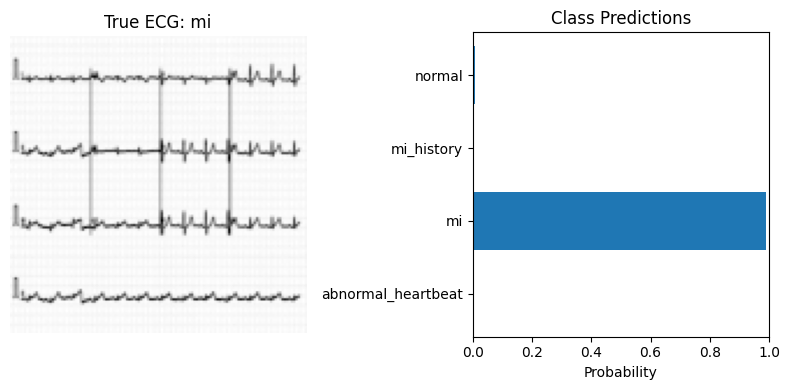

Most Probable Scenerio: mi_history


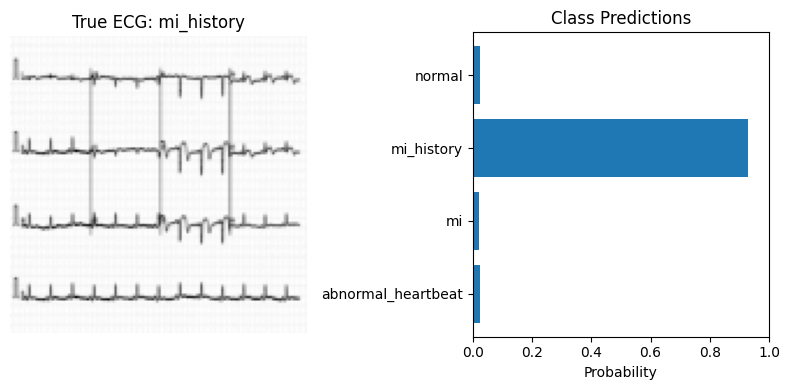

In [44]:
# Test 20 Images
class_names = test_dataset.classes
for images, labels in test_loader:  # Iterate directly over batches
    for i in range(images.size(0)):  # Iterate over images in the batch
        probabilities = predict(model, images[i].unsqueeze(0), device)
        ## Print Most Probable
        print(
            f"Most Probable Scenerio: {test_dataset.classes[np.argmax(probabilities)]}"
        )
        ###
        visualize_predictions(images[i], probabilities, class_names, labels[i])
        plt.tight_layout()
        plt.show()
    break

---

# <center> <u> Saving Model </u> </center>

In [45]:
PATH = "/content/drive/MyDrive/colab_notebooks/projects/ecg/ecg_classifier.pth"

In [46]:
# Save Model
torch.save(model.state_dict(), PATH)

In [34]:
# # Load Model

# model = ECG_Classifier(num_classes = 4)
# model.load_state_dict(torch.load(PATH, weights_only=True))
# model.eval()

---

In [35]:
# # Load just the weights
# # Note: You need to define the model architecture first

# model = torch.load('full_model.pth', map_location=torch.device(DEVICE))
# model.eval()

# # Example inference
# def predict(model, image_tensor, device):
#     model.eval()
#     with torch.no_grad():
#         # image should be
#         image_tensor = image_tensor.to(device)
#         outputs = model(image_tensor)
#         probabilities = torch.nn.functional.softmax(outputs, dim=1)
#     return probabilities.cpu().numpy().flatten()

# # Example usage (NOTICE THAT THE IMAGE IS OF SIZE torch.Size([BATCH_SIZE, 3, 128, 128])])
# class_names = test_dataset.classes
# for images, labels in test_loader:  # Iterate directly over batches
#     for i in range(images.size(0)):  # Iterate over images in the batch
#         probabilities = predict(model, images[i].unsqueeze(0), device)
#         ## Print Most Probable
#         print(f'Most Probable Scenerio: {test_dataset.classes[np.argmax(probabilities)]}')
#         ###
#         visualize_predictions(images[i], probabilities, class_names, labels[i])
#         plt.tight_layout()
#         plt.show()
#     break